In [1]:
import importlib
import utils
importlib.reload(utils)
import utils.data
importlib.reload(utils.data)
import utils.snf
importlib.reload(utils.snf)
import dataset
importlib.reload(dataset)
import models
importlib.reload(models)
import utils.train_val_test
importlib.reload(utils.train_val_test)

print("libraries reloaded!")

libraries reloaded!


## Baseline SNF

In [30]:
from utils.data import read_MoGCN_data
import os

data_path = "data/train"
omics_file_names = ["fpkm_data.csv", "gistic_data.csv", "rppa_data.csv"]
gt_file_name = "sample_classes.csv"

omics_data, gt_data, samples_list, classes_list = read_MoGCN_data(
    omics_paths=[os.path.join(data_path, file) for file in omics_file_names],
    gt_data_path=os.path.join(data_path, gt_file_name),
)

./results/baseline


/home/davide/miniconda3/envs/omics/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/davide/miniconda3/envs/omics/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/davide/miniconda3/envs/omics/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/davide/miniconda3/envs/omics/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


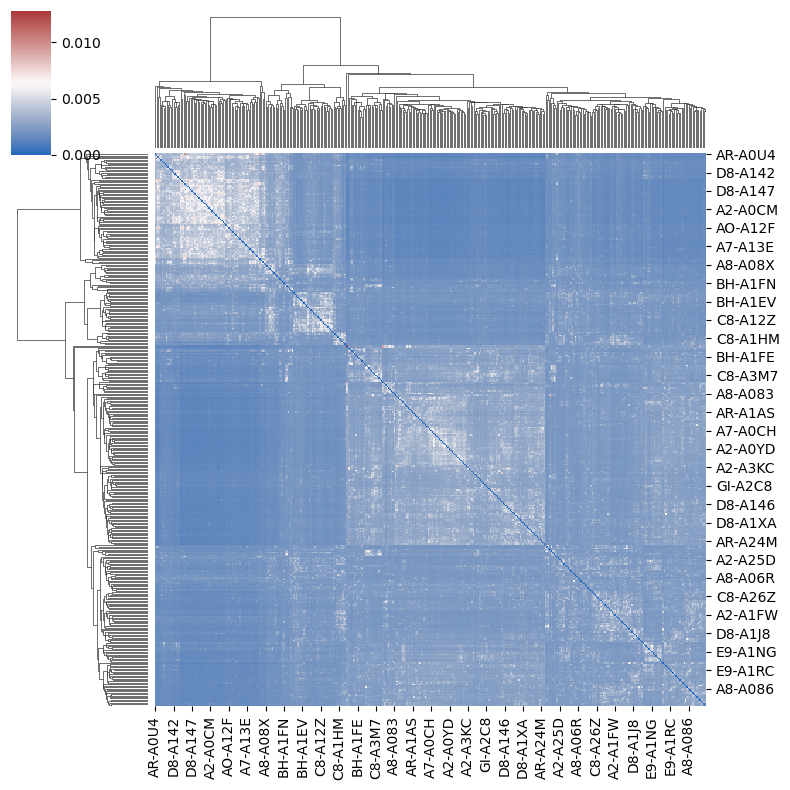

In [31]:
from utils.snf import run_snf
from utils.data import make_path

output_path = make_path("./results/baseline")
print(output_path)

fused_net = run_snf(omics_data, output_path, k=20, mu=0.5, metric="sqeuclidean")

In [43]:
fused_net

array([[0.        , 0.0014861 , 0.0026473 , ..., 0.00243796, 0.00273739,
        0.00222274],
       [0.0014861 , 0.        , 0.00166642, ..., 0.00266701, 0.00150109,
        0.00226689],
       [0.0026473 , 0.00166642, 0.        , ..., 0.00258892, 0.00366908,
        0.00215671],
       ...,
       [0.00243796, 0.00266701, 0.00258892, ..., 0.        , 0.00391324,
        0.00378023],
       [0.00273739, 0.00150109, 0.00366908, ..., 0.00391324, 0.        ,
        0.00227498],
       [0.00222274, 0.00226689, 0.00215671, ..., 0.00378023, 0.00227498,
        0.        ]])

In [32]:
from utils.snf import evaluate_snf

evaluate_snf(fused_net, classes_list)

0.6522320263113002

In [37]:
from utils.snf import get_laplace

get_laplace("./results/baseline/SNF_fused_matrix.csv")

array([[0.5       , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.11111111, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.5       , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.5       , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.2       ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.33333333]])

## Train Baseline AE

In [2]:
from utils.data import read_MoGCN_data
import os

data_path = "data/train"
omics_file_names = ["fpkm_data.csv", "gistic_data.csv", "rppa_data.csv"]
gt_file_name = "sample_classes.csv"

train_omics_data, train_gt_data, _, _ = read_MoGCN_data(
    omics_paths=[os.path.join(data_path, file) for file in omics_file_names],
    gt_data_path=os.path.join(data_path, gt_file_name),
)

data_path = "data/val"
val_omics_data, val_gt_data, _, _ = read_MoGCN_data(
    omics_paths=[os.path.join(data_path, file) for file in omics_file_names],
    gt_data_path=os.path.join(data_path, gt_file_name),
)

In [82]:
from dataset import MoGCN_Dataset
from torch.utils.data import DataLoader
from models import MoGCN_AE
from torch import optim, nn
import torch
from utils.train_val_test import train_loop, setup_seed, save_checkpoint


setup_seed()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 32
lr = 0.001
num_epochs = 100

# Train Dataset
train_MoGCN = MoGCN_Dataset(train_omics_data, train_gt_data)
train_loader = DataLoader(train_MoGCN, batch_size=batch_size, shuffle=True)

# Val Dataset
val_MoGCN = MoGCN_Dataset(val_omics_data, val_gt_data)
val_loader = DataLoader(val_MoGCN, batch_size=batch_size, shuffle=True)

# Model Initialisation
model = MoGCN_AE(
    train_MoGCN.input_dims,
    loss_fn=[nn.MSELoss(reduction="mean")] * 3,
)

optimizer = optim.Adam(model.parameters(), lr=lr)
model.to(DEVICE)

loss_ls = train_loop(
    model,
    optimizer,
    train_loader,
    output_path="./checkpoints",
    num_epochs=100,
    val_data=val_loader,
    early_stopping_mode="val_loss",
)

epoch: 1 | train loss: 2.8602  | val loss: 2.3082
epoch: 5 | train loss: 0.7296  | val loss: 0.5964
epoch: 10 | train loss: 0.3060  | val loss: 0.3172
epoch: 15 | train loss: 0.2532  | val loss: 0.2602
epoch: 20 | train loss: 0.2375  | val loss: 0.2632
epoch: 25 | train loss: 0.2269  | val loss: 0.2387
epoch: 30 | train loss: 0.2236  | val loss: 0.2322
epoch: 35 | train loss: 0.2136  | val loss: 0.2166
epoch: 40 | train loss: 0.2138  | val loss: 0.2254
Early stopped training at epoch 40

Best epoch: 34 | val_loss 0.2163


<Axes: >

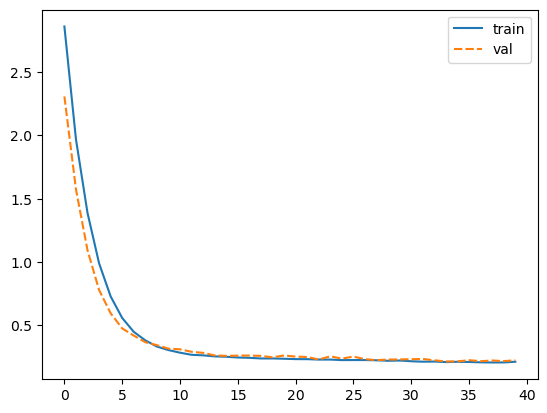

In [83]:
import seaborn as sns
import pandas as pd

sns.lineplot(data=pd.DataFrame(loss_ls))

T-SNE KL Divergence:  0.6165666580200195


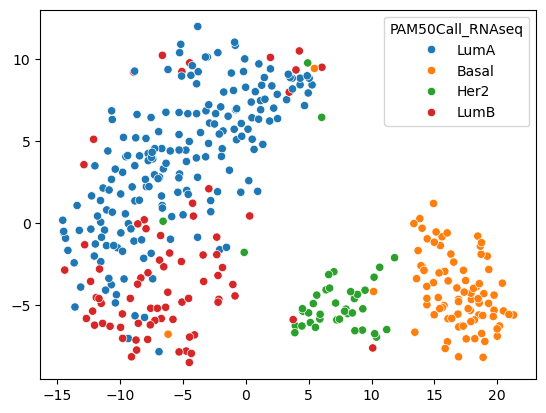

In [84]:
from utils.train_val_test import save_latent_data
model = torch.load("./checkpoints/MoGCN_AE.pkl")
kl_divergence = save_latent_data(train_MoGCN, model, "./results/baseline")

## Train Baseline GCN

In [10]:
from utils.data import read_MoGCN_data
import os

data_path = "data/train"
omics_file_names = ["fpkm_data.csv", "gistic_data.csv", "rppa_data.csv"]
gt_file_name = "sample_classes.csv"

train_omics_data, train_gt_data, _, _ = read_MoGCN_data(
    omics_paths=[os.path.join(data_path, file) for file in omics_file_names],
    gt_data_path=os.path.join(data_path, gt_file_name),
)

data_path = "data/val"
val_omics_data, val_gt_data, _, _ = read_MoGCN_data(
    omics_paths=[os.path.join(data_path, file) for file in omics_file_names],
    gt_data_path=os.path.join(data_path, gt_file_name),
)

In [11]:
from models import GCN
from dataset import MoGCN_Dataset
from torch import optim
import torch
from utils.train_val_test import train_loop, setup_seed
from utils.snf import get_laplace, run_snf

setup_seed()
DEVICE = torch.device("cuda")

# Hyperparameters
lr = 0.001
weight_decay = 0.01
num_epochs = 150
latent_space_dim = 100

# Dataset
train_MoGCN = MoGCN_Dataset(train_omics_data, train_gt_data)
val_MoGCN = MoGCN_Dataset(val_omics_data, val_gt_data)

encoder_decoder = torch.load("./checkpoints/MoGCN_AE.pkl")

train_adj = get_laplace(run_snf(train_omics_data))
val_adj = get_laplace(run_snf(val_omics_data))

train_MoGCN.set_latent_space(encoder_decoder.get_latent_space(train_MoGCN))
train_MoGCN.set_adj_matrix(train_adj)

val_MoGCN.set_latent_space(encoder_decoder.get_latent_space(val_MoGCN))
val_MoGCN.set_adj_matrix(val_adj)

print("Data loaded")

Data loaded


##### Losses with Tolerance=5

epoch: 1 | train loss: 1.3078  | val loss: 1.2934  | accuracy: 0.4772727272727273  | f1 score: 0.3084
epoch: 5 | train loss: 1.2125  | val loss: 1.2501  | accuracy: 0.4772727272727273  | f1 score: 0.3084
epoch: 10 | train loss: 1.1715  | val loss: 1.2537  | accuracy: 0.4772727272727273  | f1 score: 0.3084
Early stopped training at epoch 11

Best epoch: 5 | val_loss 1.2501


<Axes: >

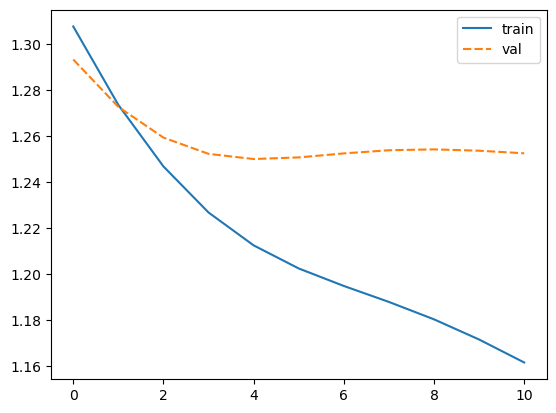

In [12]:
import seaborn as sns
import pandas as pd
from utils.train_val_test import train_loop

# Model Initialisation
model = GCN(latent_space_dim)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
model.to(DEVICE)

# Train
loss_ls, cm = train_loop(
    model,
    optimizer,
    train_MoGCN,
    output_path="./checkpoints",
    num_epochs=100,
    val_data=val_MoGCN,
    early_stopping_mode="val_loss",
    tolerance=5
)

sns.lineplot(data=pd.DataFrame(loss_ls))

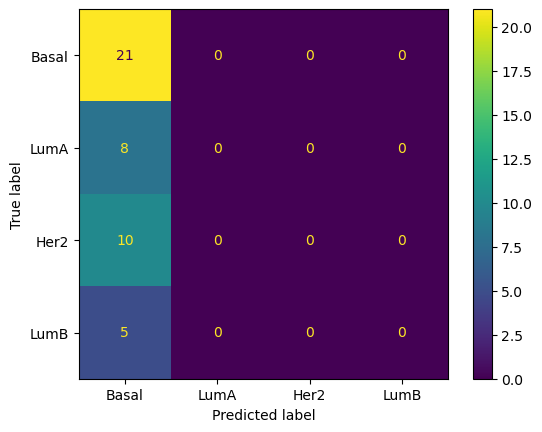

In [13]:
from sklearn.metrics import (
    ConfusionMatrixDisplay,
)
import matplotlib.pyplot as plt
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_MoGCN.gt_labels.unique(), )
cm_display.plot()
plt.show()

##### Losses with Tolerance=100

In [9]:
import seaborn as sns
import pandas as pd

# Model Initialisation
model = GCN(latent_space_dim)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
model.to(DEVICE)

# Train
loss_ls = train_loop(
    model,
    optimizer,
    train_MoGCN,
    output_path="./checkpoints",
    num_epochs=100,
    val_data=val_MoGCN,
    early_stopping_mode="accuracy",
    tolerance=100
)

epoch: 1 | train loss: 1.3676  | val loss: 1.3234  | accuracy: 47.72727272727273
epoch: 5 | train loss: 1.2294  | val loss: 1.2474  | accuracy: 47.72727272727273
epoch: 10 | train loss: 1.1996  | val loss: 1.2606  | accuracy: 47.72727272727273
epoch: 15 | train loss: 1.1553  | val loss: 1.2532  | accuracy: 47.72727272727273
epoch: 20 | train loss: 1.0974  | val loss: 1.2496  | accuracy: 47.72727272727273
epoch: 25 | train loss: 1.0200  | val loss: 1.2508  | accuracy: 47.72727272727273
epoch: 30 | train loss: 0.9260  | val loss: 1.2543  | accuracy: 47.72727272727273
epoch: 35 | train loss: 0.8275  | val loss: 1.2637  | accuracy: 47.72727272727273
epoch: 40 | train loss: 0.7442  | val loss: 1.2940  | accuracy: 47.72727272727273
epoch: 45 | train loss: 0.6819  | val loss: 1.3267  | accuracy: 47.72727272727273
epoch: 50 | train loss: 0.6342  | val loss: 1.3771  | accuracy: 47.72727272727273
epoch: 55 | train loss: 0.5967  | val loss: 1.4404  | accuracy: 47.72727272727273
epoch: 60 | train 

<Axes: >

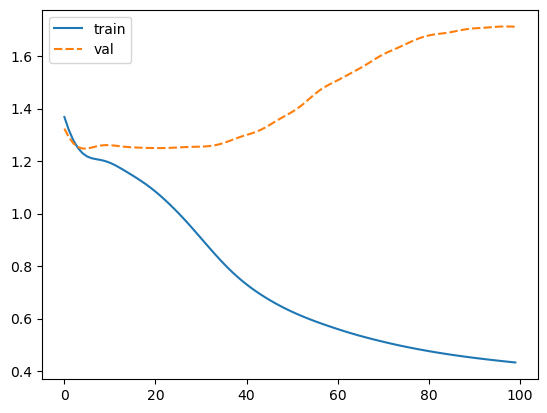

In [10]:
sns.lineplot(data=pd.DataFrame(loss_ls))

T-SNE KL Divergence:  0.354128897190094


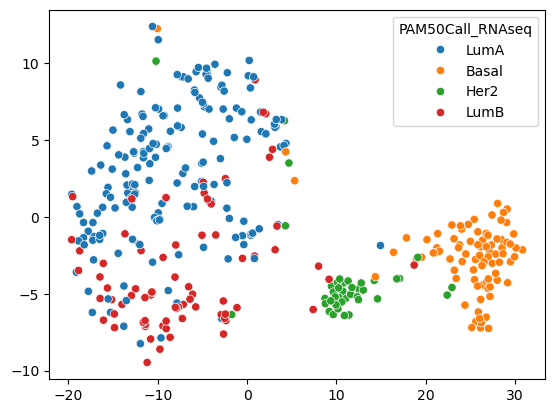

In [62]:
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd
from utils.train_val_test import save_latent_data

model = torch.load("./checkpoints/MoGCN_GCN.pkl")
kl_divergence = save_latent_data(train_MoGCN, model, "./results/baseline")

T-SNE KL Divergence:  -11.393569946289062


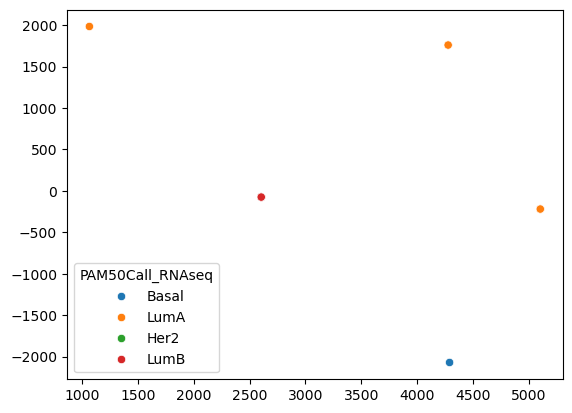

In [63]:
from utils.train_val_test import save_latent_data
kl_divergence = save_latent_data(val_MoGCN, model, "./results/baseline", perplexity=40)